# Matching FEMA and social media data based on location

This jupyuter file is to load and visualize the FEMA and social media data with the same location, i.e., census block ID. The second part will build  the old simpel neural network and use the paired inputs and labels to train.

The data looks a lot but we only need a few columns.
1. We use the 'rpfvl' (Real property damage amount observed by FEMA) values and 'ppfvl' (FEMA Verified Loss captured during inspection of personal property) from the FEMA csv file. This is the labels. 
2. We need the 'censusBlockId' in FEMA and the derived 'GEOID10' using tweet point tags. Only 1-2% percent of tweets have location information. This data is used to match/pair inputs (tweet) and labels (damage). 
3. Tweets are collected using its API.
4. Model is simple. Note that we are still looking for a good vectorizer. The current HashingVectorizer is not the best because it produces mostly zeros. 

In [1]:
import requests
import pandas as pd

# OpenFEMA Dataset: Individual Assistance Housing Registrants - Large Disasters - v1

In [2]:
iahrld = pd.read_csv('C:/Users/piyalong/Microsoft AI for humanitarian/IndividualAssistanceHousingRegistrantsLargeDisasters (1).csv')

In [3]:
'censusBlockId' in iahrld.columns

True

In [4]:
'rpfvl' in iahrld.columns

True

In [5]:
'ppfvl' in iahrld.columns

True

In [6]:
iahrld.columns

Index(['disasterNumber', 'damagedCity', 'damagedStateAbbreviation',
       'damagedZipCode', 'householdComposition', 'grossIncome', 'specialNeeds',
       'ownRent', 'residenceType', 'homeOwnersInsurance', 'floodInsurance',
       'inspected', 'rpfvl', 'habitabilityRepairsRequired', 'destroyed',
       'waterLevel', 'floodDamage', 'foundationDamage',
       'foundationDamageAmount', 'roofDamage', 'roofDamageAmount',
       'tsaEligible', 'tsaCheckedIn', 'rentalAssistanceEligible',
       'rentalAssistanceAmount', 'repairAssistanceEligible', 'repairAmount',
       'replacementAssistanceEligible', 'replacementAmount', 'sbaEligible',
       'renterDamageLevel', 'rentalAssistanceEndDate', 'rentalResourceCity',
       'rentalResourceStateAbbreviation', 'rentalResourceZipCode',
       'primaryResidence', 'personalPropertyEligible', 'ppfvl',
       'censusBlockId', 'censusYear', 'id'],
      dtype='object')

In [7]:
iahrld.disasterNumber

0          4337
1          4339
2          4332
3          4337
4          4337
           ... 
5550058    4337
5550059    4337
5550060    4337
5550061    4339
5550062    4586
Name: disasterNumber, Length: 5550063, dtype: int64

The FEMA disaster index for hurricane Harvey is 4332  hence we use it. Next we group the records by location, i.e., censusblockID. This is done for both fema and social media data.

In [8]:
harvey_iahrld=iahrld[iahrld.disasterNumber==4332]
harvey_iahrld
print("Total records: {} with unique census ID: {}".format(len(harvey_iahrld),len(harvey_iahrld.groupby('censusBlockId'))))

Total records: 895636 with unique census ID: 88482


In [9]:
FEMA_grouped=harvey_iahrld.groupby('censusBlockId')

In [10]:
FEMA_ids = list(FEMA_grouped.groups.keys())

In [11]:
FEMA_ids[:10]

[60855033302006.0,
 120110507023006.0,
 120111104042001.0,
 220039505004006.0,
 220090301001034.0,
 220190014004011.0,
 220190036002067.0,
 220239702012254.0,
 220330037015017.0,
 220330038043005.0]

In [12]:
harvey_iahrld['ppfvl'].dropna()

2             0.00
24          935.73
34            0.00
42            0.00
43            0.00
            ...   
5550026    1457.74
5550027     834.79
5550038       0.00
5550048       0.00
5550049       0.00
Name: ppfvl, Length: 584156, dtype: float64

In [13]:
harvey_iahrld['rpfvl'].dropna()

24          7887.68
42           804.18
54             0.00
65            20.72
71           448.08
             ...   
5549773    13153.24
5549863    23167.03
5549960     5628.61
5549977      579.56
5550009     2830.20
Name: rpfvl, Length: 213459, dtype: float64

# Read social media data

In [14]:
tweets=pd.read_csv('D:/20230413_Harvey_TX_twitter_point_with_blockid.csv')

In [15]:
tweets.shape

(15104, 27)

In [16]:
tweets

,Unnamed: 0.2,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,possibly_sensitive,lang,geo,conversation_id,author_id,public_metrics,...,text,id,place_id,place,place_coor,zipcode,interset,is_point,geometry,GEOID10
0,1,1,1,1,False,en,{'place_id': '07d9ca6de0486000'},9.084680e+17,2.828491e+09,"{'retweet_count': 2, 'reply_count': 0, 'like_c...",...,Family and Faculty come together to recognize ...,9.084680e+17,07d9ca6de0486000,"{'type': 'Feature', 'bbox': [-106.286140441894...","[-106.28614044189453, 31.637645721435547, -106...",79927.0,NaN,1,POINT (405251.63437970506 1069011.4891847298),4.814101e+14
1,2,2,2,2,False,en,{'place_id': '07d9ca6de0486000'},9.084680e+17,2.828491e+09,"{'retweet_count': 3, 'reply_count': 0, 'like_c...",...,An awesome return of recognizing GOODER schola...,9.084680e+17,07d9ca6de0486000,"{'type': 'Feature', 'bbox': [-106.286140441894...","[-106.28614044189453, 31.637645721435547, -106...",79927.0,NaN,1,POINT (405251.63437970506 1069011.4891847298),4.814101e+14
2,3,4,4,4,False,en,{'place_id': '07d9ca6de0486000'},9.084670e+17,2.828491e+09,"{'retweet_count': 1, 'reply_count': 0, 'like_c...",...,Meet Mr. Alaniz one of the GOODER additions to...,9.084670e+17,07d9ca6de0486000,"{'type': 'Feature', 'bbox': [-106.286140441894...","[-106.28614044189453, 31.637645721435547, -106...",79927.0,NaN,1,POINT (405251.63437970506 1069011.4891847298),4.814101e+14
3,4,13,13,13,False,en,{'place_id': '07d9ee7b96885000'},9.084150e+17,1.232237e+08,"{'retweet_count': 2, 'reply_count': 0, 'like_c...",...,Have you already snagged this seasons ultimate...,9.084150e+17,07d9ee7b96885000,"{'type': 'Feature', 'bbox': [-106.320100614742...","[-106.32010061474236, 31.67553212898165, -106....",79907.0,NaN,1,POINT (402281.41546973947 1073379.7754995143),4.814100e+14
4,5,19,19,19,False,en,{'place_id': '07d9e491ce484000'},9.083660e+17,3.011527e+09,"{'retweet_count': 9, 'reply_count': 0, 'like_c...",...,Thank you @ElPasoElectric and Mr. Garcia for p...,9.083660e+17,07d9e491ce484000,"{'type': 'Feature', 'bbox': [-106.291069785917...","[-106.29106978591747, 31.658059223457908, -106...",79927.0,NaN,1,POINT (404914.1335972445 1071293.0594618716),4.814101e+14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15099,208941,210970,476,476,False,en,{'place_id': '2c0346ba4b733e24'},9.009777e+17,4.824882e+07,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",...,"Weather Map for Fri, Aug 25, 1:45 AM #noaaweat...",9.009777e+17,2c0346ba4b733e24,"{'type': 'Feature', 'bbox': [-102.406328090222...","[-102.40632809022276, 31.85695825717272, -102....",79763.0,NaN,1,POINT (772754.1416801636 1078848.4471224227),4.813500e+14
15100,208947,210976,482,482,False,en,{'place_id': '2c0346ba4b733e24'},9.009200e+17,1.075626e+09,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",...,Prepare your selfs #HurricaneHarvey,9.009200e+17,2c0346ba4b733e24,"{'type': 'Feature', 'bbox': [-102.382856036265...","[-102.38285603626584, 31.866271370623615, -102...",79761.0,NaN,1,POINT (774992.6175441993 1079830.777402107),4.813500e+14
15101,208953,210982,488,488,False,en,{'place_id': '2c0346ba4b733e24'},9.008913e+17,8.784023e+17,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",...,issa birthday girl #19 Ã°ÂÂÂÃ°ÂÂÂ,9.008913e+17,2c0346ba4b733e24,"{'type': 'Feature', 'bbox': [-102.319984436035...","[-102.31998443603516, 31.882360458374023, -102...",79762.0,NaN,1,POINT (780965.8825937912 1081484.5557618828),4.813500e+14
15102,208997,211026,532,532,False,en,{'place_id': '2c0346ba4b733e24'},9.004407e+17,2.861874e+08,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",...,When you make yourself better by reading the W...,9.004407e+17,2c0346ba4b733e24,"{'type': 'Feature', 'bbox': [-102.36033325, 31...","[-102.36033325, 31.8348011, -102.36033325, 31....",79761.0,NaN,1,POINT (777044.7740655345 1076303.6286189544),4.813500e+14


In [17]:
tweets.columns

Index(['Unnamed: 0.2', 'Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1',
       'possibly_sensitive', 'lang', 'geo', 'conversation_id', 'author_id',
       'public_metrics', 'preview_image_url', 'url', 'media_key', 'created_at',
       'entities', 'reply_settings', 'context_annotations', 'text', 'id',
       'place_id', 'place', 'place_coor', 'zipcode', 'interset', 'is_point',
       'geometry', 'GEOID10'],
      dtype='object')

In [18]:
tweets_grouped=tweets.groupby('GEOID10')

In [19]:
tweets_ids = list(tweets_grouped.groups.keys())

In [20]:
len(set(tweets_ids))

5661

In [21]:
tweets_ids[:10]

[480019506002020.0,
 480019508002031.0,
 480050004002067.0,
 480050008003004.0,
 480050009021018.0,
 480050009022003.0,
 480079501002025.0,
 480079501003062.0,
 480079501004024.0,
 480079501005005.0]

# Match

In [22]:
overlap = set(FEMA_ids).intersection(set(tweets_ids))
print(len(overlap))

1251


In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt
import scipy
import numpy as np
import statsmodels.api as sm
from sklearn.feature_extraction.text import TfidfVectorizer,HashingVectorizer
from sklearn.model_selection import train_test_split
import collections

# different ways to vectorize the social media data

I changed the output dimension to get less zeros. You can change it more. 

In [24]:
texts=[]
ppfvls=[]
vectorizer=HashingVectorizer(n_features=128)

for ID in overlap:
    ts=tweets_grouped.get_group(ID)['text']
    fs=FEMA_grouped.get_group(ID)['ppfvl']
    
    vector = vectorizer.transform([ts.str.cat()])
    # vector = nlp(text)
    matrix=vector.A
    # print(ts,fs)
    if len(fs.dropna())==0:continue
    texts.append(matrix[0])
    ppfvls.append(fs.dropna())
    # break

In [25]:
ts

12154    Donation Warehouse at 3575 Pollok Dr #Conroe N...
12170    Hallelujah we have blue skies &amp; sun, thing...
12201    @GeorgeTakei @DeniseDresserG How dare you talk...
12203    One of my heroes is @BrandiKHOU who is sole-re...
Name: text, dtype: object

In [26]:
len(fs.dropna())

4

In [27]:
matrix

array([[ 0.        ,  0.21693046,  0.        ,  0.        ,  0.10846523,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -0.10846523,  0.10846523,  0.        ,  0.        ,
        -0.32539569,  0.        ,  0.        ,  0.        ,  0.        ,
         0.32539569,  0.        ,  0.        ,  0.21693046,  0.        ,
         0.        ,  0.        ,  0.        ,  0.10846523,  0.        ,
         0.10846523,  0.        ,  0.        , -0.10846523,  0.10846523,
         0.        ,  0.10846523,  0.        ,  0.        ,  0.        ,
        -0.10846523,  0.        ,  0.10846523,  0.        ,  0.21693046,
        -0.10846523,  0.10846523,  0.10846523,  0.        ,  0.        ,
         0.        ,  0.        , -0.21693046, -0.21693046,  0.        ,
        -0.10846523,  0.        , -0.10846523,  0.        ,  0.        ,
         0.        , -0.10846523,  0.10846523,  0.        ,  0.        ,
         0.        ,  0.        ,  0.10846523,  0. 

A lot of zeros after hashing. We want to improve that. 

In [28]:
zero_count = np.count_nonzero(matrix == 0)

# Print the count
print("Number of zeros:", zero_count)

Number of zeros: 80


In [29]:
len(texts)

1000

# Prepare the data to train a model

In [30]:
damages = [p.mean() for p in ppfvls]

In [31]:
ppfvls[5]

4602577    0.0
4653115    0.0
5066600    0.0
5241981    0.0
Name: ppfvl, dtype: float64

We do really need a data loader, but it is easier to follow the same steps for all models.

In [32]:
from torch.utils.data import DataLoader, TensorDataset,Dataset

class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index]
        y = self.labels[index]
        return x, y

In [33]:
import torch
from sklearn.model_selection import train_test_split

# Convert your data and labels to PyTorch tensors
X = np.array(texts)
y = np.array(damages)

data = torch.tensor(X, dtype=torch.float32)  # Assuming X is your data
labels = torch.tensor(y, dtype=torch.float32)  # Assuming y is your labels

# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2)

# Create custom datasets for training and testing
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index]
        y = self.labels[index]
        return x, y

# Create instances of your custom datasets for training and testing
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)


In [34]:
len(train_dataset),len(test_dataset)

(800, 200)

In [35]:
y_train.shape,y_test.shape

(torch.Size([800]), torch.Size([200]))

In [36]:
batch_size = 512  # You can adjust the batch size as needed

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [37]:
for batch in train_loader:
    inputs, targets = batch
    break

In [38]:
np.where(inputs[0] != 0)

(array([  3,  17,  22,  23,  25,  30,  38,  43,  52,  56,  69,  78,  86,
         90,  94,  96, 109, 116, 125], dtype=int64),)

In [39]:
inputs[0]

tensor([ 0.0000,  0.0000,  0.0000,  0.2000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.4000,  0.0000,  0.0000,  0.0000,  0.0000,  0.2000, -0.2000,
         0.0000,  0.2000,  0.0000,  0.0000,  0.0000,  0.0000, -0.2000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.2000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.2000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.2000,  0.0000,  0.0000,  0.0000,
        -0.2000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.2000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.2000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.2000,  0.0000,
         0.0000,  0.0000,  0.2000,  0.0000,  0.0000,  0.0000,  0.2000,  0.0000,
         0.2000,  0.0000,  0.0000,  0.00

In [40]:
inputs.shape

torch.Size([512, 128])

In [41]:
targets.view(-1, 1).shape

torch.Size([512, 1])

# Build a model

In [42]:
import torch
import torch.nn as nn
device='cpu'
class CustomNet(nn.Module):

    def __init__(self):
        super(CustomNet, self).__init__()
        # self.fc1 = nn.Linear(1024, 512)
        # self.fc2 = nn.Linear(512, 256)
        # self.fc3 = nn.Linear(256, 128)
        # self.bn1 = nn.BatchNorm1d(512)  # Batch normalization after the first linear layer
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 1)

        # self.bn2 = nn.BatchNorm1d(1)  # Batch normalization after the second linear layer
    def forward(self, x):
        
        # x = torch.relu(self.fc1(x))
        # x = torch.relu(self.fc2(x))
        # x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        return x


In [43]:
history={'train':[],'test':[]}

model = CustomNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)
criterion = nn.MSELoss().to(device)

num_epochs = 9000
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch in train_loader:
        inputs, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.view(-1, 1))
        # print(loss)
        running_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    # print(f"Epoch {epoch + 1}, Loss: {running_loss/(len(inputs)+0.001)}")
    history['train'].append(running_loss/(len(inputs)+0.001))
    
    # if test_loss>train_loss:
    #     counter+=1
    # if counter >= patience:
    #     early_stop = True
    # if early_stop:
    #     torch.save(model.state_dict(), 'test.pth')
    #     break

print("Training complete")


Training complete


Text(0, 0.5, 'MSE')

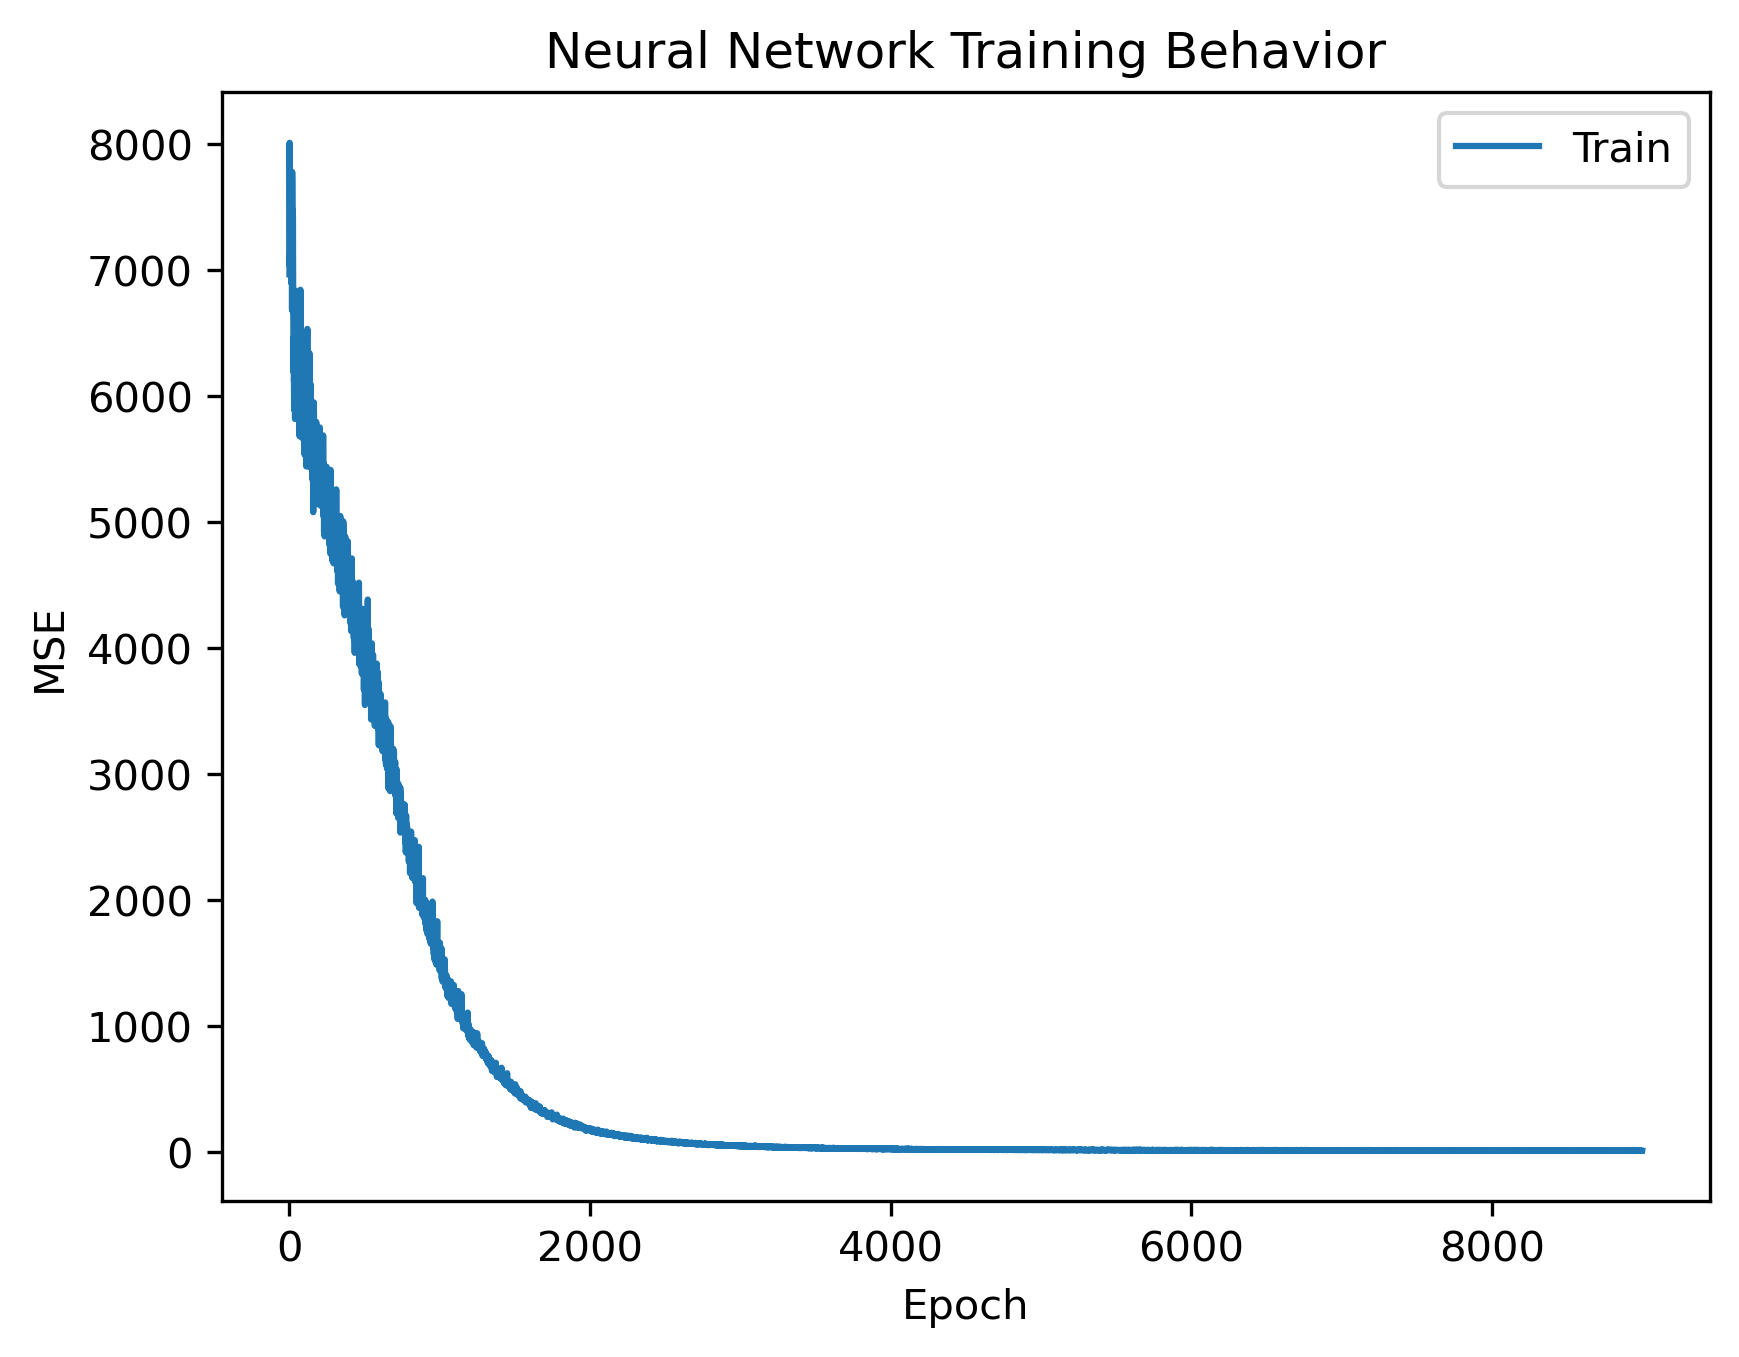

In [44]:
plt.figure(dpi=300)
plt.title('Neural Network Training Behavior')
plt.plot(history['train'],label='Train')
# plt.plot(history['test'],label='Validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MSE')
# plt.savefig('Training2.png')

# Test the model

Plot the y_pred and y_true on testing data

In [45]:
y_pred=[]
y_true=[]

for batch in test_loader:
    inputs, labels = batch
    
    outputs = model(inputs)
    y_pred.append(outputs.detach().numpy())
    y_true.append(labels.detach().numpy())
    
y_pred = np.concatenate(y_pred)
y_true = np.concatenate(y_true)

In [46]:
y_pred.shape

(200, 1)

In [47]:
y_true.shape

(200,)

We should see the prediction and ground truth align along the diagnal line if the model is perfect.

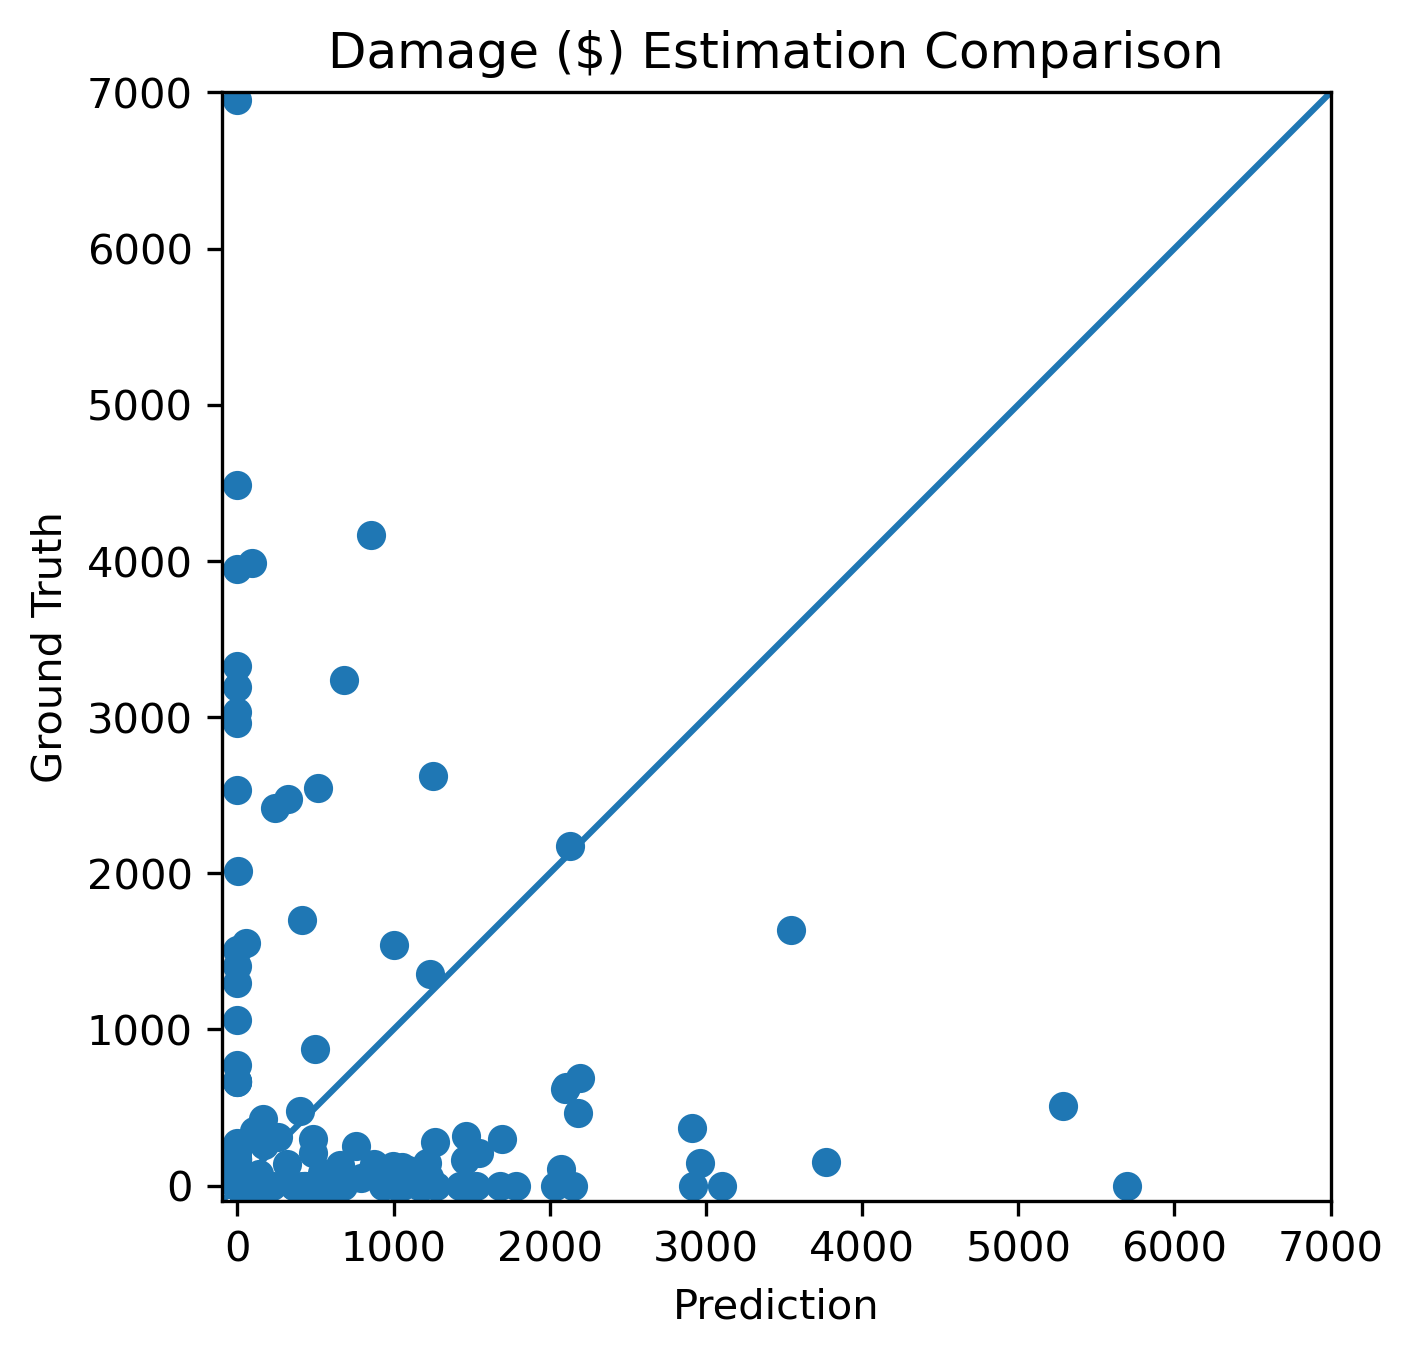

In [55]:
plt.figure(dpi=300)
plt.axes(aspect='equal')
plt.title('Damage ($) Estimation Comparison')
# for pre,gt in zip (y_pred,y_true):
#     # mae=mean_squared_error(pre,gt)
#     p = 1- mae/np.mean(gt)
    
plt.scatter(y_pred,y_true)
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
# plt.legend()
lims = [-100, 7000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
# plt.savefig('Damage Estimation Accuracy2.png')

In [56]:
errors=[]
for pred, gt in zip (y_pred,y_true):
    error=pred-gt
    errors.append(error)

In [57]:
np.array(errors).mean()

144.0455

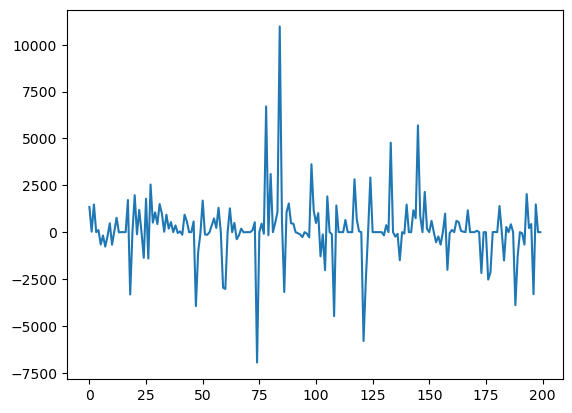

In [58]:
plt.plot(errors)

In [59]:
errors

[array([1342.4479], dtype=float32),
 array([24.97586], dtype=float32),
 array([1473.7395], dtype=float32),
 array([0.], dtype=float32),
 array([112.14204], dtype=float32),
 array([-660.6691], dtype=float32),
 array([-177.26445], dtype=float32),
 array([-774.8264], dtype=float32),
 array([-215.00647], dtype=float32),
 array([474.36844], dtype=float32),
 array([-670.69666], dtype=float32),
 array([57.908497], dtype=float32),
 array([768.181], dtype=float32),
 array([-6.8958335], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([1714.0756], dtype=float32),
 array([-3325.07], dtype=float32),
 array([0.], dtype=float32),
 array([1968.1735], dtype=float32),
 array([-113.19], dtype=float32),
 array([1185.9587], dtype=float32),
 array([0.], dtype=float32),
 array([-1368.3846], dtype=float32),
 array([1783.2885], dtype=float32),
 array([-1408.6412], dtype=float32),
 array([2542.6335], dtype=float32),
 array([509.01138], dtype=float32)

In [53]:
(y_pred-y_true).min()

-7200.0